<h1 style='font-size: 25px; color: crimson; font-family: Colonna MT; font-weight: 600; text-align: center'>Evaluating Soil Health Compliance with Agronomic Standards</h1>

---

<h1 style='font-size: 18px;  font-weight: 600'>2.0: Import Required Libraries</h1>

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from scipy.stats import shapiro, levene, skew, kurtosis 
pd.set_option('display.max_columns', 9)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("...Libraries Loaded Successfully....")

...Libraries Loaded Successfully....


<h1 style='font-size: 18px; font-weight: 600'>3.0: Import and Preprocessing Dataset</h1>

In [2]:
filepath = "./Datasets/Soil Health Data.csv"
df = pd.read_csv(filepath)
display(df.head())

,Plot ID,Soil pH,Organic Matter (%),Nitrogen (%),...,Magnesium (cmol/kg),Sulfur (mg/kg),Zinc (mg/kg),Iron (mg/kg)
0,Plot 1,6.69,2.44,0.25,...,1.96,11.90,1.70,77.00
1,Plot 1,5.89,1.63,0.25,...,1.02,7.60,2.30,109.20
2,Plot 1,6.87,2.68,0.29,...,1.49,6.40,0.92,134.80
3,Plot 1,5.84,2.97,0.30,...,1.15,13.00,1.19,88.00
4,Plot 1,6.82,4.07,0.18,...,1.25,10.00,0.88,71.00


In [3]:
df = df[['Plot ID', 'Soil pH', 'Organic Matter (%)', 'Nitrogen (%)',
       'Phosphorus (mg/kg)', 'Potassium (cmol/kg)', 'Calcium (cmol/kg)',
       'Magnesium (cmol/kg)', 'Sulfur (mg/kg)',]]
df

,Plot ID,Soil pH,Organic Matter (%),Nitrogen (%),Phosphorus (mg/kg),Potassium (cmol/kg),Calcium (cmol/kg),Magnesium (cmol/kg),Sulfur (mg/kg)
0,Plot 1,6.69,2.44,0.25,16.80,0.82,11.18,1.96,11.90
1,Plot 1,5.89,1.63,0.25,23.40,1.11,6.01,1.02,7.60
2,Plot 1,6.87,2.68,0.29,20.10,1.14,11.17,1.49,6.40
3,Plot 1,5.84,2.97,0.30,17.60,0.84,6.69,1.15,13.00
4,Plot 1,6.82,4.07,0.18,13.10,0.81,4.02,1.25,10.00
...,...,...,...,...,...,...,...,...,...
145,Plot 5,6.93,3.33,0.30,18.10,1.13,13.79,2.01,13.30
146,Plot 5,6.38,3.25,0.26,27.00,0.86,11.18,1.56,11.50
147,Plot 5,6.26,3.79,0.26,15.80,0.76,7.65,1.22,11.90
148,Plot 5,6.26,2.18,0.26,27.00,0.81,16.18,1.79,11.90


<h1 style='font-size: 18px; font-weight: 600'>4.0: Exploratory Data Analysis </h1>

Now, let’s move into Exploratory Data Analysis (EDA) — an important step where we take a closer look at our dataset to understand its structure, identify patterns, detect anomalies, and get a sense of the overall distribution of soil parameters. This will help us gain valuable insights and guide the direction of our statistical tests and interpretations.

<h2 style='font-size: 17px; font-weight: 600'>4.1: Dataset Informartion Overviews</h2>


In [4]:
df.shape

(150, 9)

In [5]:
for column in df.columns.tolist(): print(f"{'-'*15} {column}")

--------------- Plot ID
--------------- Soil pH
--------------- Organic Matter (%)
--------------- Nitrogen (%)
--------------- Phosphorus (mg/kg)
--------------- Potassium (cmol/kg)
--------------- Calcium (cmol/kg)
--------------- Magnesium (cmol/kg)
--------------- Sulfur (mg/kg)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Plot ID              150 non-null    object 
 1   Soil pH              150 non-null    float64
 2   Organic Matter (%)   150 non-null    float64
 3   Nitrogen (%)         150 non-null    float64
 4   Phosphorus (mg/kg)   150 non-null    float64
 5   Potassium (cmol/kg)  150 non-null    float64
 6   Calcium (cmol/kg)    150 non-null    float64
 7   Magnesium (cmol/kg)  150 non-null    float64
 8   Sulfur (mg/kg)       150 non-null    float64
dtypes: float64(8), object(1)
memory usage: 10.7+ KB


<h4 style='font-size: 15px; font-weight: 600'>4.1.2: Columns Summary</h4>

In [7]:
def column_summary(df):
    summary_data = []
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

summary_df = column_summary(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,Plot ID,object,0,150,5,"{'Plot 1': 30, 'Plot 2': 30, 'Plot 3': 30, 'Pl..."
1,Soil pH,float64,0,150,98,"{6.53: 4, 6.67: 4, 6.59: 4, 6.55: 3, 6.34: 3, ..."
2,Organic Matter (%),float64,0,150,114,"{2.44: 3, 2.87: 3, 2.45: 2, 3.29: 2, 1.94: 2, ..."
3,Nitrogen (%),float64,0,150,102,"{0.18: 4, 0.229: 4, 0.251: 4, 0.237: 4, 0.194:..."
4,Phosphorus (mg/kg),float64,0,150,94,"{19.0: 6, 15.2: 5, 18.1: 4, 17.8: 4, 21.2: 4, ..."
5,Potassium (cmol/kg),float64,0,150,73,"{0.81: 7, 0.6: 6, 0.67: 5, 0.66: 5, 0.88: 5, 0..."
6,Calcium (cmol/kg),float64,0,150,136,"{10.55: 3, 11.67: 3, 11.18: 2, 6.69: 2, 13.71:..."
7,Magnesium (cmol/kg),float64,0,150,79,"{1.2: 5, 1.6: 4, 1.65: 4, 1.42: 4, 1.56: 4, 1...."
8,Sulfur (mg/kg),float64,0,150,85,"{11.9: 6, 11.5: 5, 12.3: 4, 10.0: 3, 11.8: 3, ..."


<h4 style='font-size: 15px; font-weight: 600'>4.1.3: Handling Duplicates Values</h4>

In [8]:
def handle_duplicates(df):
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        df.drop_duplicates(inplace=True)
        print(f"Found and removed {duplicate_count} duplicate rows successfully.")
    else:
        print("No duplicate rows found in the dataset.")


handle_duplicates(df)

No duplicate rows found in the dataset.


<h4 style='font-size: 15px;  font-weight: 600'>4.1.4: Checking Missing Values</h4>

Checking for missing values is a crucial step in data analysis to assess the completeness and reliability of the dataset. This involves identifying any columns with null or empty entries, which may affect the accuracy of statistical and machine learning models.

In [9]:
def Missig_values_info(df):   
    isna_df = df.isna().sum().reset_index(name='Missing Values Counts')
    isna_df['Proportions (%)'] = isna_df['Missing Values Counts']/len(df)*100
    return isna_df
    
isna_df = Missig_values_info(df)
isna_df

,index,Missing Values Counts,Proportions (%)
0,Plot ID,0,0.00
1,Soil pH,0,0.00
2,Organic Matter (%),0,0.00
3,Nitrogen (%),0,0.00
4,Phosphorus (mg/kg),0,0.00
5,Potassium (cmol/kg),0,0.00
6,Calcium (cmol/kg),0,0.00
7,Magnesium (cmol/kg),0,0.00
8,Sulfur (mg/kg),0,0.00


<h4 style='font-size: 15px;  font-weight: 600'>4.1.5: Exploring Invalid Entries Dtypes</h4>

Exploring invalid entries in data types involves identifying values that do not match the expected format or category within each column. This includes detecting inconsistencies such as numerical values in categorical fields, incorrect data formats, or unexpected symbols and typos. Invalid entries can lead to errors in analysis and model performance, making it essential to standardize data types and correct anomalies.

In [11]:
def simplify_dtype(dtype):
    if dtype in (int, float, np.number): return 'Numeric'
    elif np.issubdtype(dtype, np.datetime64): return 'Datetime'
    elif dtype == str: return 'String'
    elif dtype == type(None): return 'Missing'
    else: return 'Other'

def analyze_column_dtypes(df):
    all_dtypes = {'Numeric', 'Datetime', 'String', 'Missing', 'Other'}
    results = pd.DataFrame(index=df.columns, columns=list(all_dtypes), dtype=object).fillna('-')
    
    for column in df.columns:
        dtypes = df[column].apply(lambda x: simplify_dtype(type(x))).value_counts()
        percentages = (dtypes / len(df)) * 100
        for dtype, percent in percentages.items():
            if percent > 0:
                results.at[column, dtype] = f'{percent:.2f}%'  # Add % sign and format to 2 decimal places
            else:
                results.at[column, dtype] = '-'  # Add dash for 0%
    return results

results = analyze_column_dtypes(df)
display(results)

,Other,Missing,String,Numeric,Datetime
Plot ID,-,-,100.00%,-,-
Soil pH,-,-,-,100.00%,-
Organic Matter (%),-,-,-,100.00%,-
Nitrogen (%),-,-,-,100.00%,-
Phosphorus (mg/kg),-,-,-,100.00%,-
Potassium (cmol/kg),-,-,-,100.00%,-
Calcium (cmol/kg),-,-,-,100.00%,-
Magnesium (cmol/kg),-,-,-,100.00%,-
Sulfur (mg/kg),-,-,-,100.00%,-


<h2 style='font-size: 17px;  font-weight: 600'>4.2: Detection and Handling Outliers</h2>

An outlier is a data point that significantly deviates from the rest of the dataset, appearing as an unusually high or low value. Outliers may arise from errors, data entry mistakes, or natural variations, and can distort statistical analysis and machine learning models. To maintain data integrity, outliers should be detected using methods like Z-scores, IQR, or visual tools (e.g., box plots), and then handled appropriately.

<h4 style='font-size: 15px;  font-weight: 600'>4.2.1: Visualize Outliers Using Boxplots</h4>

To gain a more visual and intuitive understanding of how outliers are distributed, we can use **boxplots**. Boxplots not only show the spread and center of the data but also clearly highlight outliers as individual points outside the whiskers, making it easy to see which variables and groups have more extreme values.

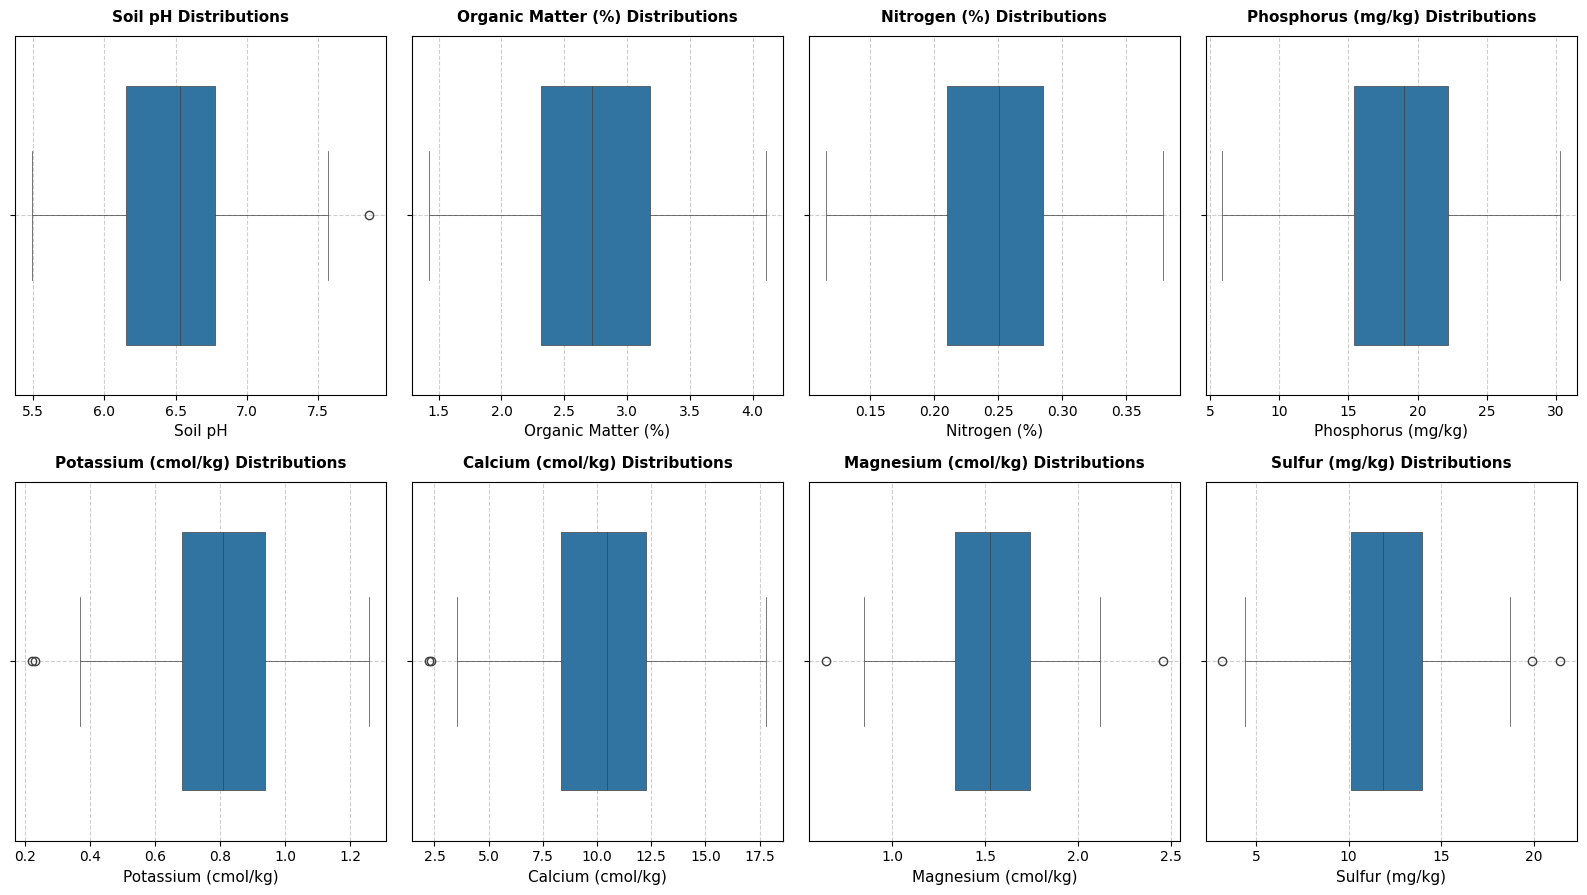

In [12]:
def plot_boxplot(df, Metrics, group_col=None):
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 4)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5* rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Metrics):
        sns.boxplot(data=df, x=df[column], fill=True, hue=group_col, ax=axes[idx], gap=0.1, linewidth=0.5)   
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
        if group_col: axes[idx].set_title(f"{column} Distributions by {group_col}", fontsize=11, pad=10, fontweight='bold')
        
        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
        if group_col: axes[idx].legend(frameon=False)
        
    
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
Metrics = df.select_dtypes(include=[np.number]).columns
plot_boxplot(df, Metrics)

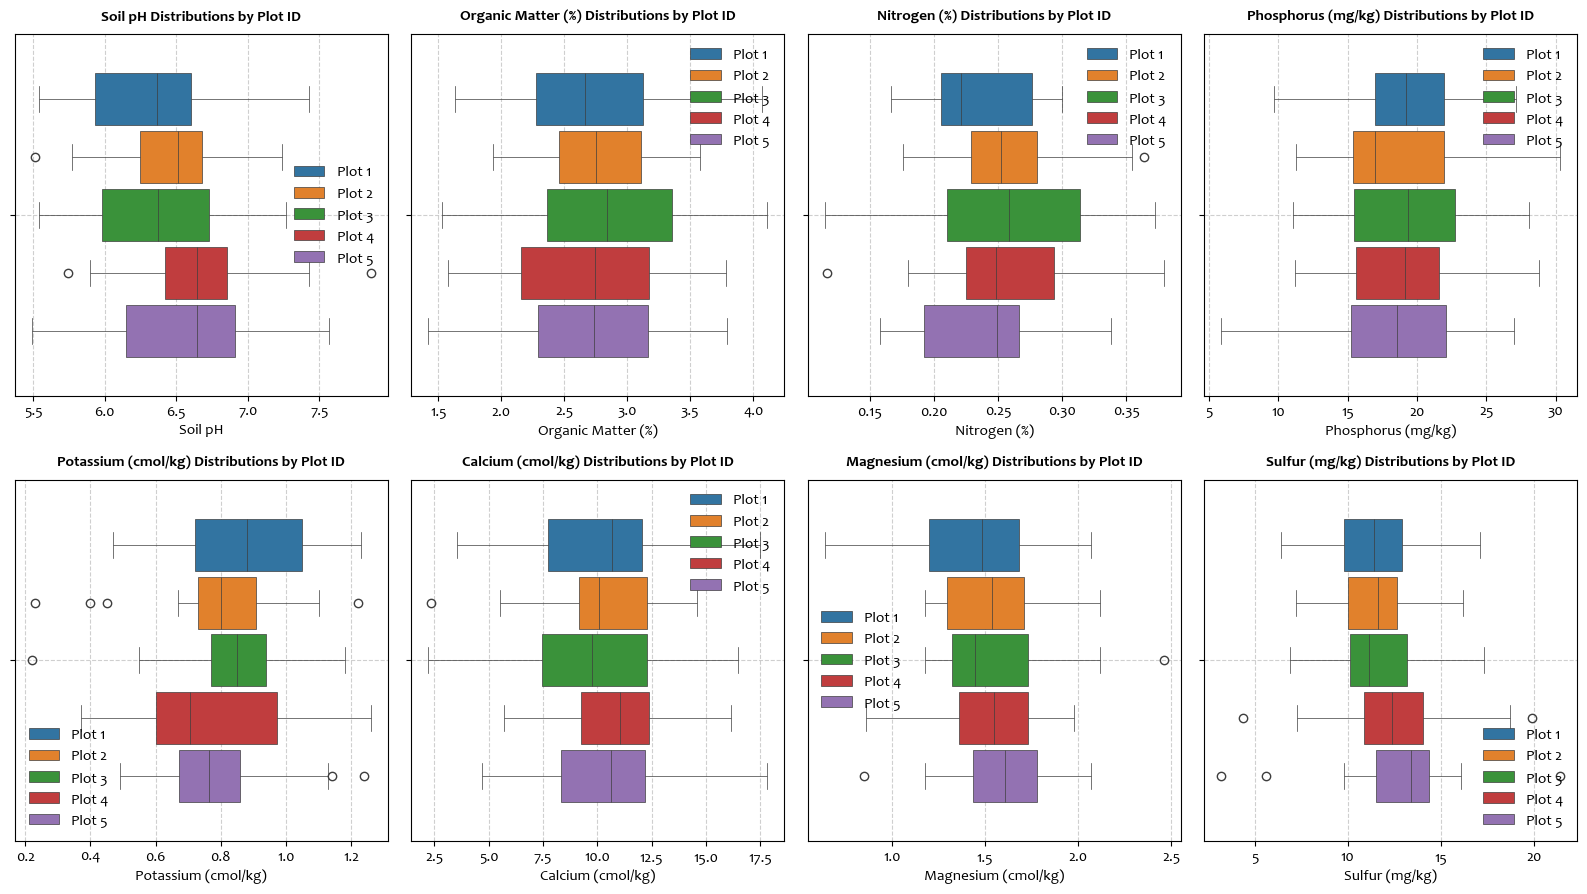

In [13]:
Metrics = df.select_dtypes(include=[np.number]).columns
plot_boxplot(df, Metrics, group_col='Plot ID')

<h4 style='font-size: 15px; color: blue;  font-weight: 600'>4.2.2: Explore Outlier Anomalies Using the IQR Method</h4>

Now, let’s explore outliers in our data using the Interquartile Range (IQR) method. This approach helps us identify extreme values by checking which data points fall far below or above the typical range for each variable. By detecting these anomalies, both overall and within groups, we can better understand the data’s variability and decide if any values need closer attention or cleaning.

In [14]:
def detect_outliers_overall(df):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    outlier_counts = {}
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
        outlier_counts[col] = count
    
    total_obs = df.shape[0]
    result = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
    result.loc['Total Observations'] = [total_obs]
    
    return result.astype(int)

overall_outliers = detect_outliers_overall(df)
display(overall_outliers)

,Outlier Count
Soil pH,1
Organic Matter (%),0
Nitrogen (%),0
Phosphorus (mg/kg),0
Potassium (cmol/kg),2
Calcium (cmol/kg),2
Magnesium (cmol/kg),2
Sulfur (mg/kg),3
Total Observations,150


The current implementation only returns the counts and proportions of outliers in the dataset, but it doesn’t show which specific groups those outliers belong to. To get a clearer picture, we can create plots that compare outlier distributions across groups, helping us identify which groups are most affected.

In [15]:
def detect_outliers_by_group(df, group_col):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    outlier_summary = pd.DataFrame(index=numeric_cols)

    grouped = df.groupby(group_col)
    for group_name, group_data in grouped:
        outlier_counts = []
        for col in numeric_cols:
            Q1 = group_data[col].quantile(0.25)
            Q3 = group_data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            count = group_data[(group_data[col] < lower) | (group_data[col] > upper)].shape[0]
            outlier_counts.append(count)
        outlier_summary[group_name] = outlier_counts

    total_row = df.groupby(group_col).size()
    outlier_summary.loc["Total Observations"] = total_row

    return outlier_summary.fillna(0).astype(int)

outliers_table = detect_outliers_by_group(df, group_col='Plot ID')
display(outliers_table)


,Plot 1,Plot 2,Plot 3,Plot 4,Plot 5
Soil pH,0,1,0,2,0
Organic Matter (%),0,0,0,0,0
Nitrogen (%),0,1,0,1,0
Phosphorus (mg/kg),0,0,0,0,0
Potassium (cmol/kg),0,4,1,0,2
Calcium (cmol/kg),0,1,0,0,0
Magnesium (cmol/kg),0,0,1,0,1
Sulfur (mg/kg),0,0,0,2,3
Total Observations,30,30,30,30,30


<h2 style='font-size: 17px; font-weight: 600'>4.3: Statistic Description of The Datasets</h2>

Let's take a moment to quickly explore some essential statistics of our dataset. By using the `describe()` function in pandas, we can generate a summary of key metrics for each numerical column in the dataset. This gives us a bird's-eye view of the data, helping us understand the general distribution and characteristics of the values.

In [16]:
summary_stats = df.describe().T.reset_index()
summary_stats

,index,count,mean,std,min,25%,50%,75%,max
0,Soil pH,150.00,6.47,0.47,5.49,6.15,6.53,6.78,7.86
1,Organic Matter (%),150.00,2.75,0.59,1.42,2.31,2.73,3.18,4.11
2,Nitrogen (%),150.00,0.25,0.05,0.12,0.21,0.25,0.29,0.38
3,Phosphorus (mg/kg),150.00,18.92,4.61,5.90,15.40,19.00,22.20,30.30
4,Potassium (cmol/kg),150.00,0.82,0.20,0.22,0.68,0.81,0.94,1.26
5,Calcium (cmol/kg),150.00,10.37,3.17,2.23,8.32,10.45,12.27,17.81
6,Magnesium (cmol/kg),150.00,1.54,0.29,0.64,1.34,1.52,1.74,2.46
7,Sulfur (mg/kg),150.00,12.00,3.00,3.20,10.12,11.85,13.97,21.40


<h4 style='font-size: 15px; font-weight: 600'>4.3.1:  Distribution of Soil Parameters</h4>

Let’s explore the distribution of soil parameters across the entire set of field samples collected  by examining key statistics. The **Mean** gives us the average value, while the **Median** provides the middle value, offering a more robust measure against outliers. The **Mode** identifies the most frequent value. **Standard Deviation** and **Variance** show how much the data deviates from the mean, with larger values indicating greater spread. The **Range** reveals the difference between the maximum and minimum values, while **Skewness** measures the symmetry of the distribution. Lastly, **Kurtosis** tells us about the presence of outliers by analyzing the "tailedness" of the distribution. Together, these metrics give us a comprehensive view of how the data is distributed and guide us in identifying any potential issues like skewness or outliers.

In [17]:
def compute_overall_distribution_stats(df):
    results = []
    for col in df.select_dtypes(include=[np.number]).columns:
        mean = df[col].mean()
        median = df[col].median()
        mode = df[col].mode().iloc[0] if not df[col].mode().empty else np.nan
        std_dev = df[col].std()
        variance = df[col].var()
        value_range = df[col].max() - df[col].min()
        skewness_val = skew(df[col], nan_policy='omit')  # Skewness
        kurtosis_val = kurtosis(df[col], nan_policy='omit')  # Kurtosis


        results.append({
            'Parameter': col,
            'Mean': mean,
            'Median': median,
            'Mode': mode,
            'Standard Deviation': std_dev,
            'Variance': variance,
            'Range': value_range,
            
            'Skewness': skewness_val,
            'Kurtosis': kurtosis_val
        })

    
    result_df = pd.DataFrame(results)
    return result_df

pd.set_option('display.max_columns', 10) 
Continuous_variables_distribution = compute_overall_distribution_stats(df)
Continuous_variables_distribution

,Parameter,Mean,Median,Mode,Standard Deviation,Variance,Range,Skewness,Kurtosis
0,Soil pH,6.47,6.53,6.53,0.47,0.22,2.37,0.02,-0.25
1,Organic Matter (%),2.75,2.73,2.44,0.59,0.34,2.69,0.18,-0.52
2,Nitrogen (%),0.25,0.25,0.18,0.05,0.00,0.26,0.08,-0.24
3,Phosphorus (mg/kg),18.92,19.00,19.00,4.61,21.26,24.40,0.07,-0.16
4,Potassium (cmol/kg),0.82,0.81,0.81,0.20,0.04,1.04,-0.10,0.07
5,Calcium (cmol/kg),10.37,10.45,10.55,3.17,10.03,15.58,-0.05,-0.12
6,Magnesium (cmol/kg),1.54,1.52,1.20,0.29,0.09,1.82,0.05,0.20
7,Sulfur (mg/kg),12.00,11.85,11.90,3.00,9.02,18.20,0.07,0.45


<h4 style='font-size: 15px; font-weight: 600'>4.3.2:  Distribution of Soil Parameters Across the Entire field</h4>

Now, let's explore the **overall mean values**, **ranges**, and **coefficient of variation (CV)** of the soil parameters across the entire set of field samples collected. This step provides a comprehensive view of the general soil condition without focusing on individual plots. By analyzing the mean values, we can understand the average nutrient levels present in the field. The range (minimum to maximum values) highlights the spread and variability of each parameter, indicating whether certain nutrients are deficient or excessively abundant in some areas. Meanwhile, the coefficient of variation (CV) offers insight into the relative variability of each parameter in percentage terms, helping to identify which nutrients are consistently distributed across the field and which show higher inconsistency. This overall analysis is essential for gaining a holistic understanding of the soil's health status and guiding effective field-wide management decisions.


In [18]:
def overall_nutrient_summary(df):
    metrics = df.select_dtypes(include=np.number).columns.tolist()
    
    summary = pd.DataFrame(index=metrics)

    summary["Mean"] = df[metrics].mean().round(2)
    summary["SEM"] = df[metrics].sem().round(2)
    summary["Mean ± SEM"] = summary["Mean"].astype(str) + " ± " + summary["SEM"].astype(str)
    summary["Min"] = df[metrics].min().round(2)
    summary["Max"] = df[metrics].max().round(2)
    summary["Range"] = summary["Min"].astype(str) + " – " + summary["Max"].astype(str)
    summary['Standard Deviation'] =  df[metrics].std()
    summary["%CV"] = (df[metrics].std() / df[metrics].mean() * 100).round(2)
    
    return summary[["Mean ± SEM", "Range", "Standard Deviation", "%CV"]].reset_index().rename(columns={'index': 'Parameter'})


overall_summary_df = overall_nutrient_summary(df)
display(overall_summary_df)


,Parameter,Mean ± SEM,Range,Standard Deviation,%CV
0,Soil pH,6.47 ± 0.04,5.49 – 7.86,0.47,7.23
1,Organic Matter (%),2.75 ± 0.05,1.42 – 4.11,0.59,21.32
2,Nitrogen (%),0.25 ± 0.0,0.12 – 0.38,0.05,20.50
3,Phosphorus (mg/kg),18.92 ± 0.38,5.9 – 30.3,4.61,24.37
4,Potassium (cmol/kg),0.82 ± 0.02,0.22 – 1.26,0.20,24.92
5,Calcium (cmol/kg),10.37 ± 0.26,2.23 – 17.81,3.17,30.52
6,Magnesium (cmol/kg),1.54 ± 0.02,0.64 – 2.46,0.29,19.12
7,Sulfur (mg/kg),12.0 ± 0.25,3.2 – 21.4,3.00,25.03


<h4 style='font-size: 15px; font-weight: 600'>4.3.3:  Mean Comparisons of Soil Parameters Across Different Farm Plots</h4>

Now, let's explore the **mean comparisons of soil parameters across different farm plots**. This analysis helps us understand how nutrient levels and soil properties vary from one plot to another within the same field or study area. By comparing the average values of each parameter per plot, we can identify spatial patterns or inconsistencies in soil fertility, such as plots that are more acidic, nutrient-deficient, or organically rich compared to others. This comparison is crucial for making informed decisions about **site-specific soil management**, allowing for targeted interventions like plot-based fertilization, liming, or organic matter enrichment. It also helps in identifying which plots align more closely with recommended agronomic standards and which ones may require corrective actions to improve productivity and sustainability.


In [19]:
def summary_stats(df, group=''):
    Metrics = df.select_dtypes(include=np.number).columns.tolist()
    df_without_location = df.drop(columns=[group])
    grand_mean = df_without_location[Metrics].mean()
    sem = df_without_location[Metrics].sem()
    cv = df_without_location[Metrics].std() / df_without_location[Metrics].mean() * 100
    grouped = df.groupby(group)[Metrics].agg(['mean', 'sem']).reset_index()
    
    summary_df = pd.DataFrame()
    for col in Metrics:
        summary_df[col] = grouped.apply(
            lambda x: f"{x[(col, 'mean')]:.2f} ± {x[(col, 'sem')]:.2f}", axis=1
        )
    
    summary_df.insert(0, group, grouped[group])
    grand_mean_row = ['Grand Mean'] + grand_mean.tolist()
    sem_row = ['SEM'] + sem.tolist()
    cv_row = ['%CV'] + cv.tolist()
    
    summary_df.loc[len(summary_df)] = grand_mean_row
    summary_df.loc[len(summary_df)] = sem_row
    summary_df.loc[len(summary_df)] = cv_row
    
    return summary_df


results = summary_stats(df, group='Plot ID')
results.T

,0,1,2,3,4,5,6,7
Plot ID,Plot 1,Plot 2,Plot 3,Plot 4,Plot 5,Grand Mean,SEM,%CV
Soil pH,6.33 ± 0.08,6.49 ± 0.07,6.37 ± 0.09,6.64 ± 0.08,6.53 ± 0.10,6.47,0.04,7.23
Organic Matter (%),2.70 ± 0.11,2.76 ± 0.08,2.88 ± 0.12,2.67 ± 0.12,2.73 ± 0.11,2.75,0.05,21.32
Nitrogen (%),0.24 ± 0.01,0.26 ± 0.01,0.26 ± 0.01,0.25 ± 0.01,0.24 ± 0.01,0.25,0.00,20.50
Phosphorus (mg/kg),19.09 ± 0.78,18.42 ± 0.90,19.32 ± 0.77,19.33 ± 0.82,18.45 ± 0.97,18.92,0.38,24.37
Potassium (cmol/kg),0.88 ± 0.04,0.80 ± 0.04,0.84 ± 0.04,0.77 ± 0.05,0.79 ± 0.03,0.82,0.02,24.92
Calcium (cmol/kg),10.21 ± 0.62,10.32 ± 0.50,9.84 ± 0.66,10.82 ± 0.47,10.69 ± 0.63,10.37,0.26,30.52
Magnesium (cmol/kg),1.48 ± 0.07,1.54 ± 0.04,1.54 ± 0.06,1.54 ± 0.05,1.59 ± 0.05,1.54,0.02,19.12
Sulfur (mg/kg),11.32 ± 0.53,11.62 ± 0.42,11.75 ± 0.50,12.45 ± 0.66,12.85 ± 0.59,12.00,0.25,25.03


<h4 style='font-size: 15px; font-weight: 600'>4.3.3: Visual Distribution</h4>

To gain more intuitive insights, let's explore the data distribution through visualizations. Visual tools like histograms, box plots, and scatter plots help us easily identify patterns, trends, and outliers in the data. These visuals provide a clear representation of how data is spread across variables, allowing for quicker interpretation and a deeper understanding of the dataset’s structure and relationships.

<h5 style='font-size: 14px; font-weight: 600'>4.3.3.1:  Histograms</h5>

Now, let's visualize the distribution of each soil parameter across the entire field using histograms. This will help us understand the spread, central tendency, and potential outliers within the overall dataset.


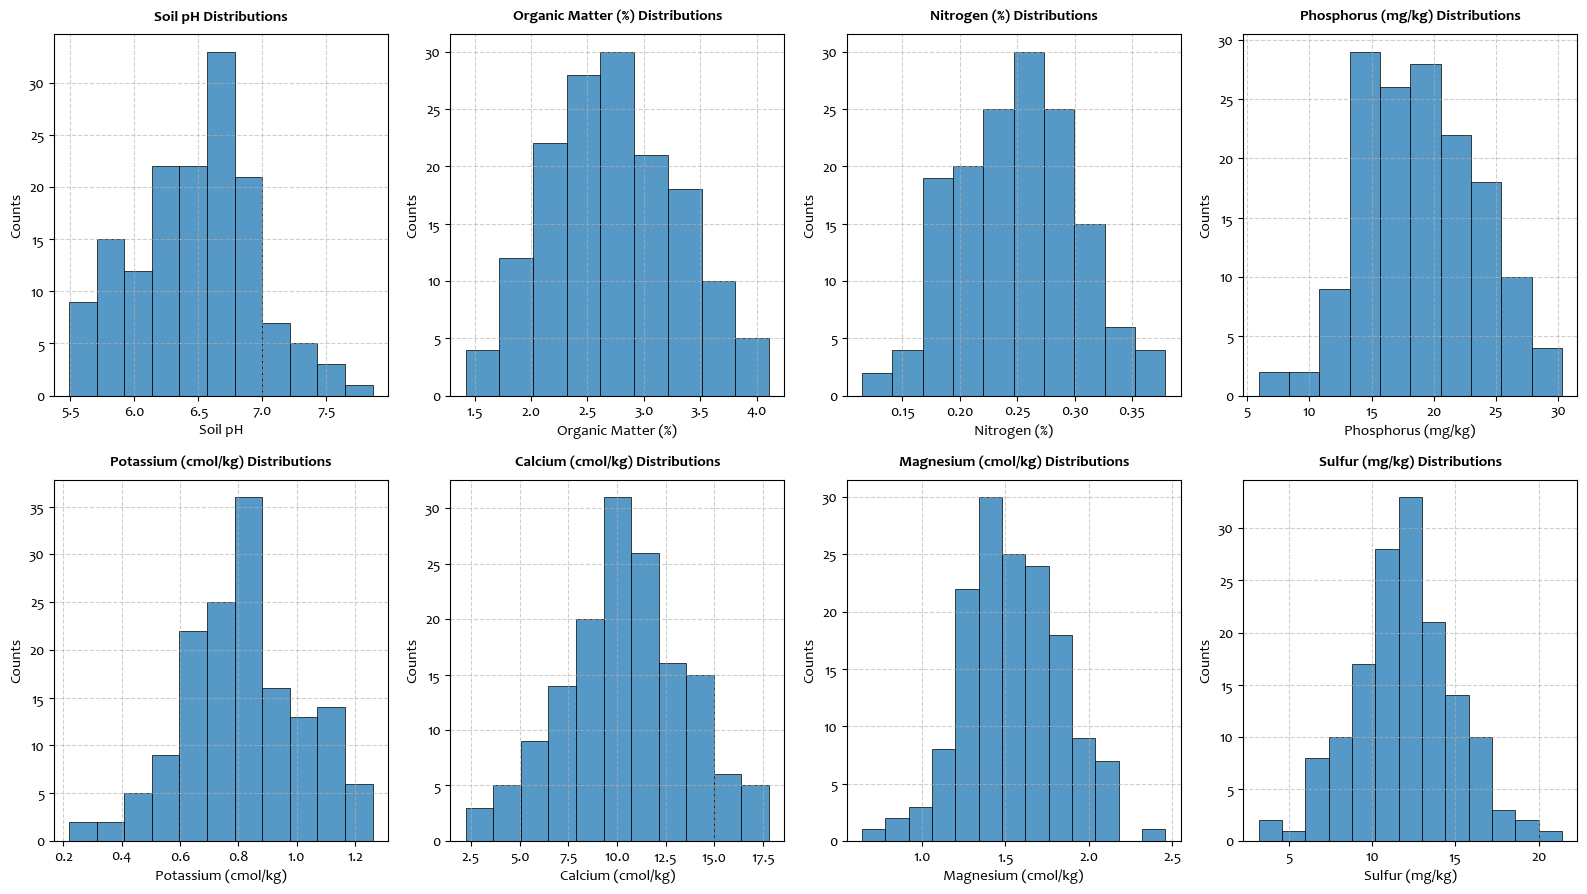

In [103]:
def hitoplot(df, Metrics, group_col=None):
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 4)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5* rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Metrics):
        sns.histplot(data=df, x=df[column], fill=True, hue=group_col, ax=axes[idx], linewidth=0.5)
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
        if group_col: axes[idx].set_title(f"{column} Distributions by {group_col}", fontsize=11, pad=10, fontweight='bold')
        
        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].set_ylabel('Counts', fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
    
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
Metrics = df.select_dtypes(include=[np.number]).columns
hitoplot(df, Metrics)

Now, let's group the soil data by **Plot ID** and visualize the distribution of each parameter using histograms. This allows us to compare how nutrient levels and soil properties vary across different plots within the field.

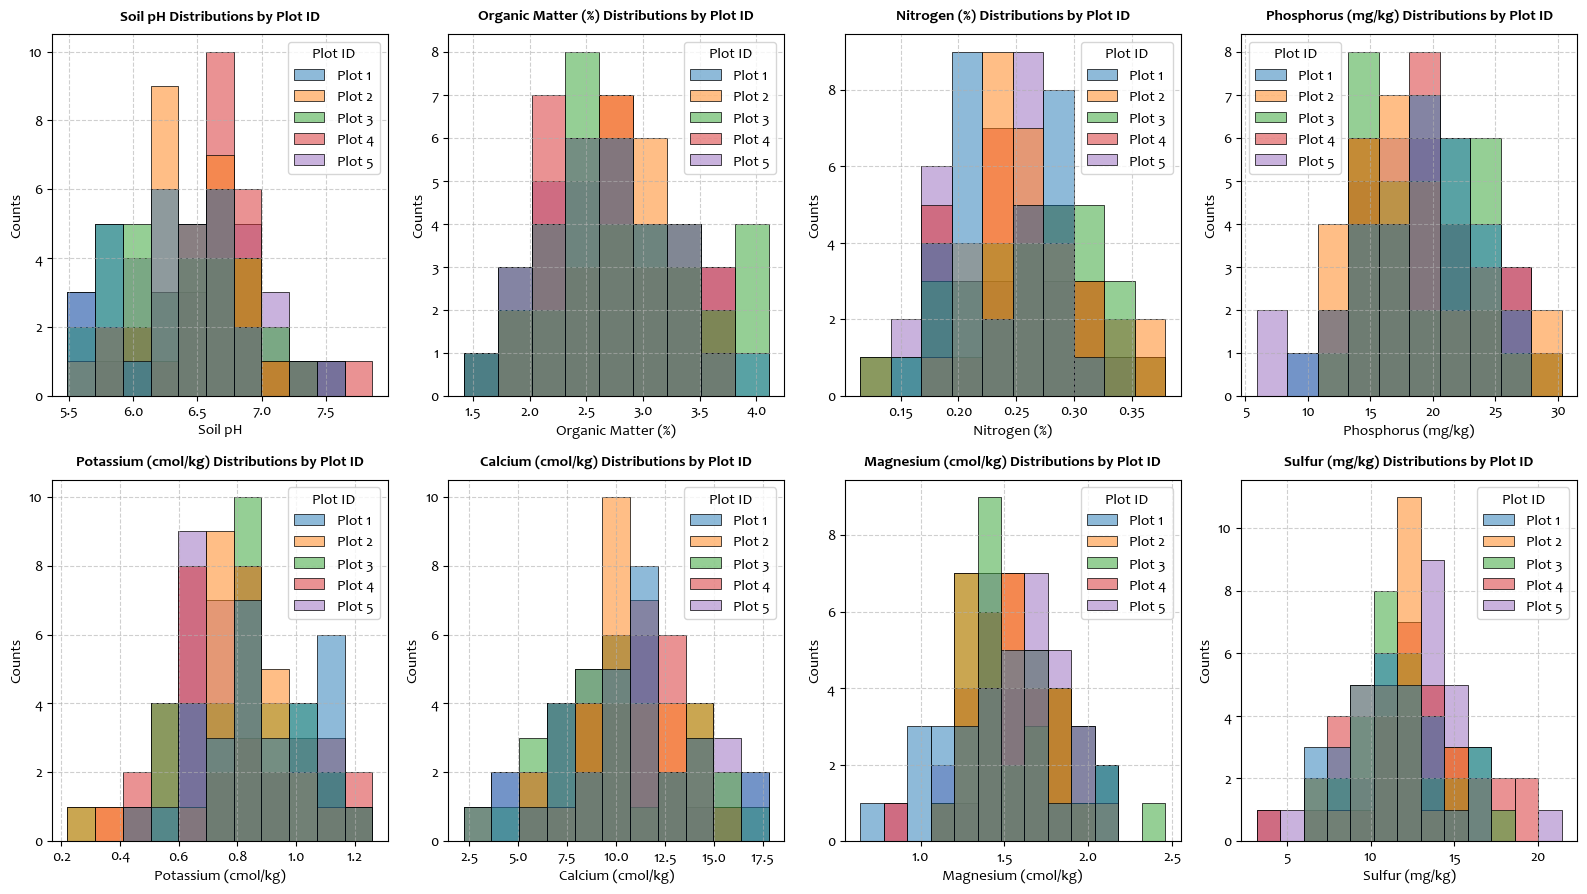

In [104]:
Metrics = df.select_dtypes(include=[np.number]).columns
hitoplot(df, Metrics, group_col='Plot ID')

<h5 style='font-size: 14px; font-weight: 600'>4.3.3.2:  Kernel Density Estimation (KDE) plots</h5>

Now, let's visualize the **overall distribution of soil parameters** across the entire field using **Kernel Density Estimation (KDE) plots**. These plots provide a smooth curve representing the probability density of each parameter, helping us understand the underlying distribution and identify skewness, peaks, or multimodal patterns in the data.


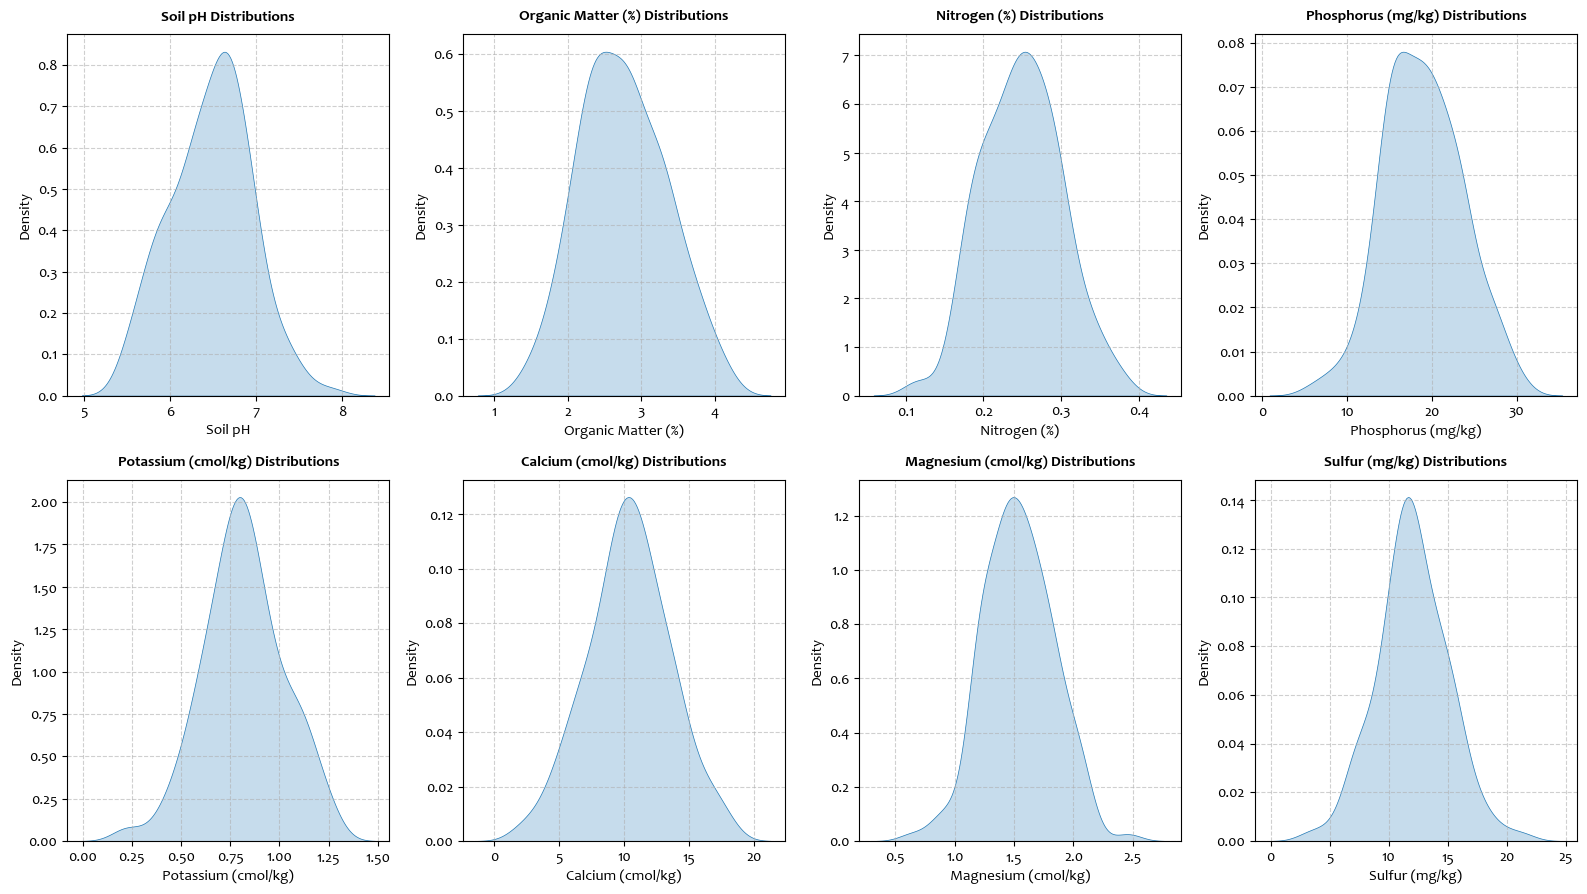

In [106]:
def plot_kdeplot(df, Metrics, group_col=None):
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 4)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5* rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Metrics):
        sns.kdeplot(data=df, x=df[column], fill=True, hue=group_col, ax=axes[idx], linewidth=0.5)  
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
        if group_col: axes[idx].set_title(f"{column} Distributions by {group_col}", fontsize=11, pad=10, fontweight='bold')
        
        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].set_ylabel('Density', fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
    
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
Metrics = df.select_dtypes(include=[np.number]).columns
plot_kdeplot(df, Metrics)

Now, let's generate **Kernel Density Estimation (KDE) plots grouped by Plot ID** to visualize how the distribution of each soil parameter varies across different plots. This will help us compare nutrient variability between plots and identify unique distribution patterns or inconsistencies within specific areas of the field.


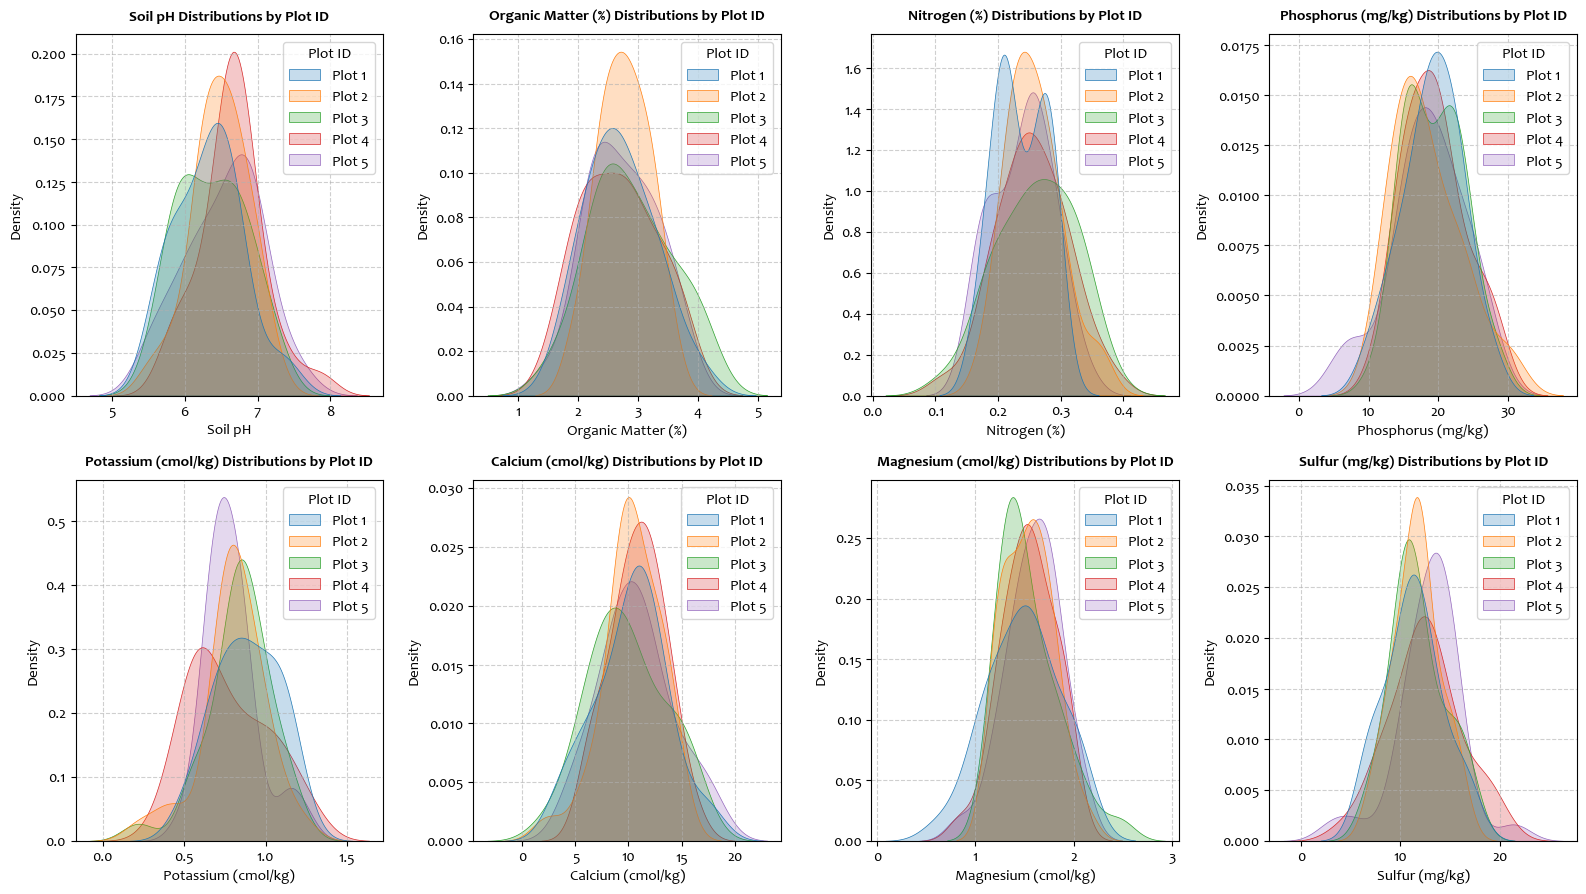

In [107]:
Metrics = df.select_dtypes(include=[np.number]).columns
plot_kdeplot(df, Metrics, group_col='Plot ID')

<h5 style='font-size: 14px; font-weight: 600'>4.3.3.2:  Boxplots</h5>

Now, let's create **boxplots for each soil parameter across the entire field** to visualize their overall distribution. Boxplots are useful for identifying the median, interquartile range (IQR), and potential outliers, giving us a clear picture of how each nutrient or soil property is spread across all collected samples.


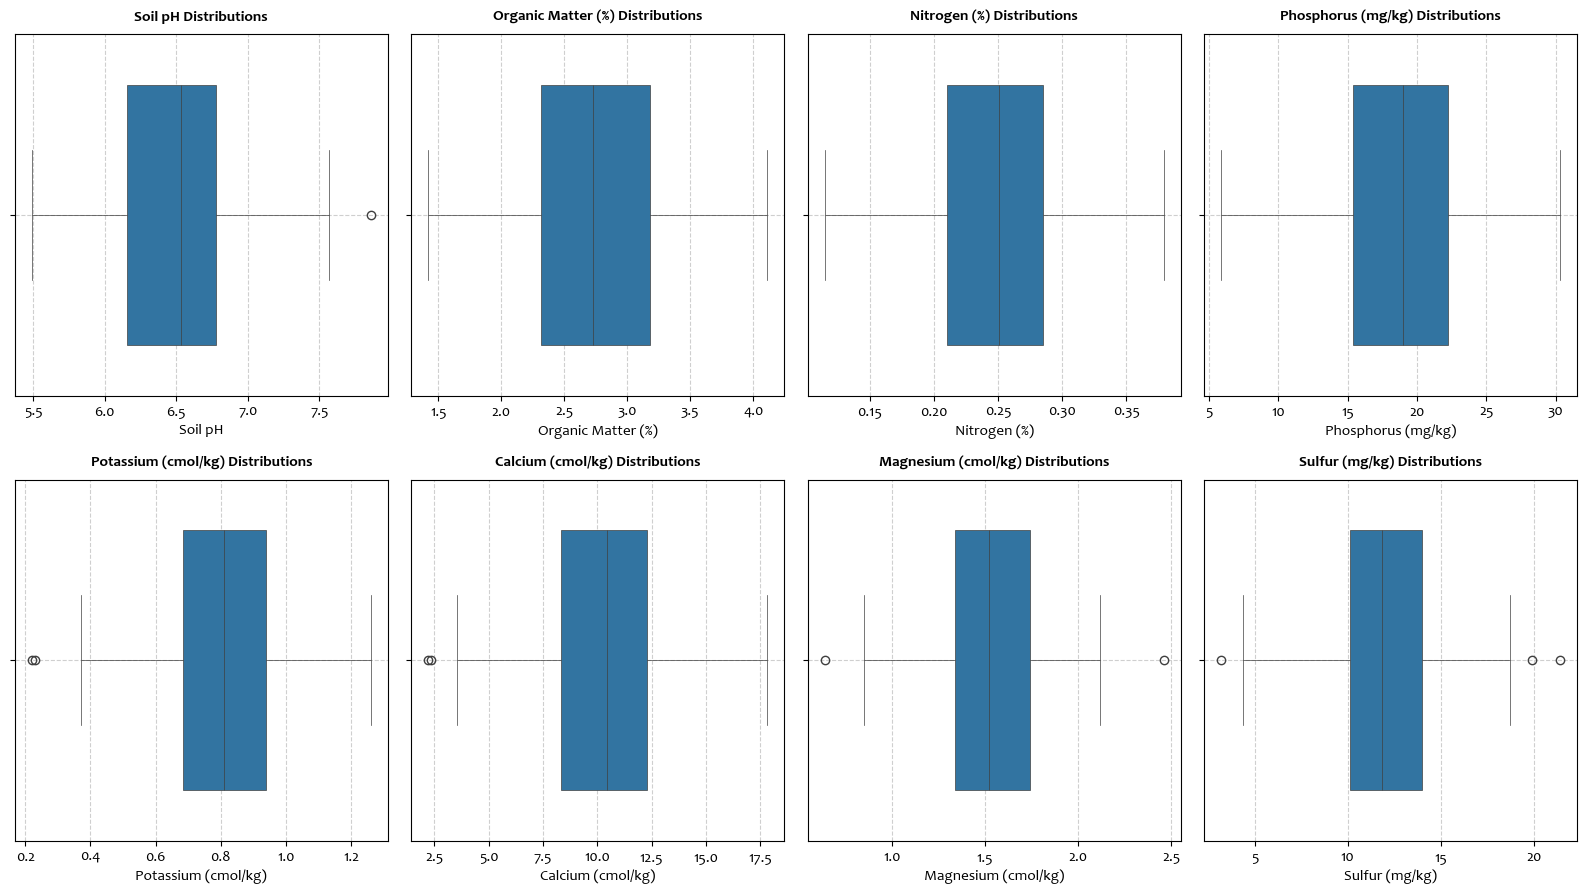

In [108]:
def plot_boxplot(df, Metrics, group_col=None):
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 4)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5* rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Metrics):
        sns.boxplot(data=df, x=df[column], fill=True, hue=group_col, ax=axes[idx], gap=0.1, linewidth=0.5)   
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
        if group_col: axes[idx].set_title(f"{column} Distributions by {group_col}", fontsize=11, pad=10, fontweight='bold')
        
        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
        if group_col: axes[idx].legend(frameon=False)
        
    
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
Metrics = df.select_dtypes(include=[np.number]).columns
plot_boxplot(df, Metrics)

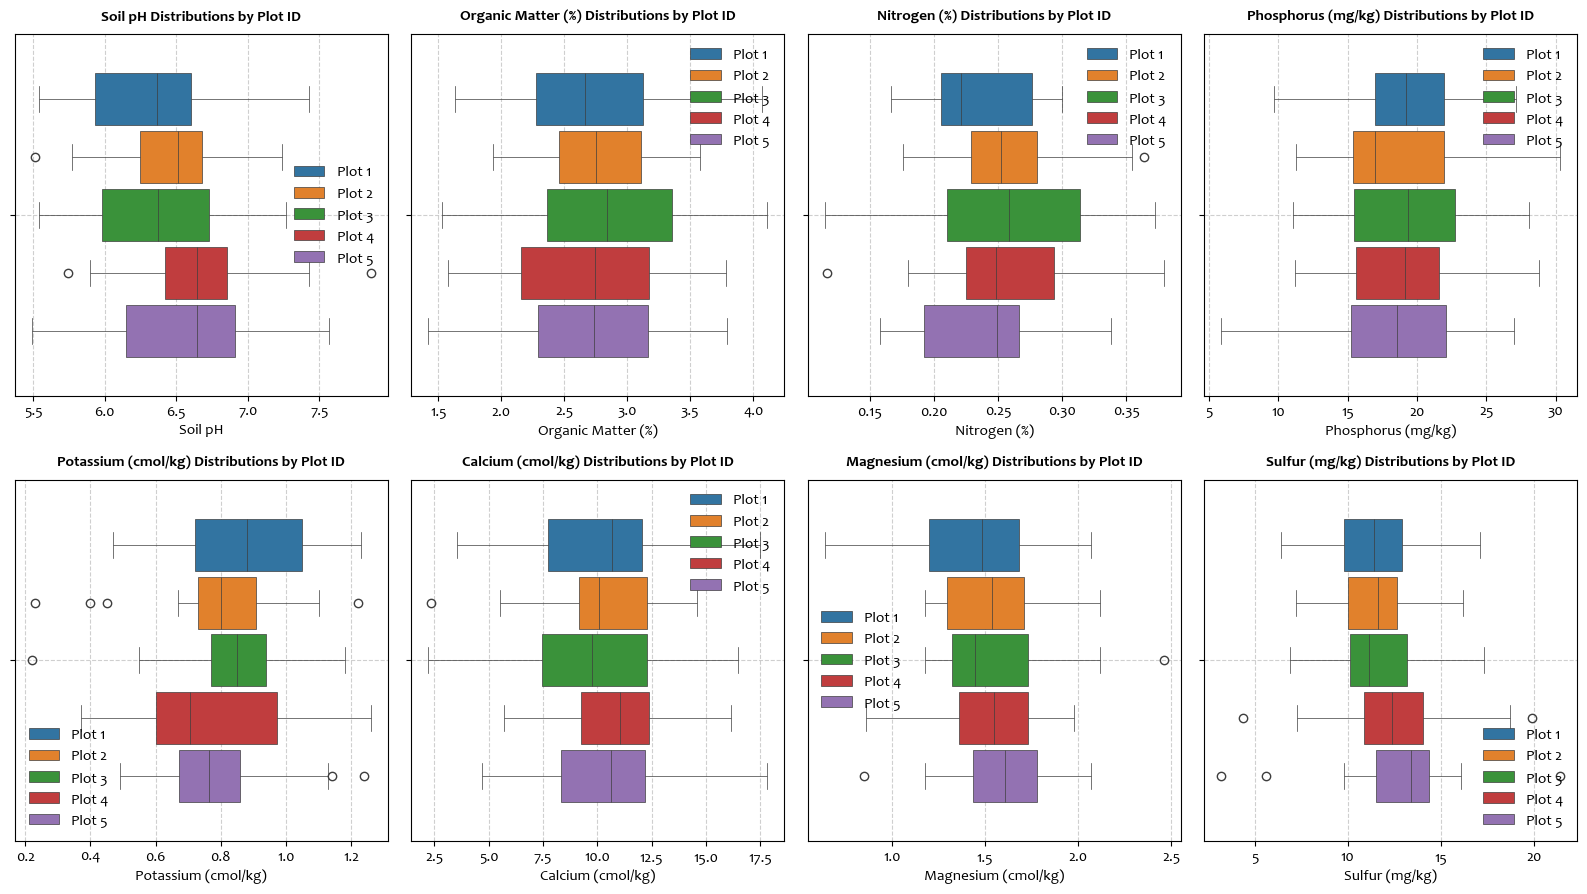

In [109]:
Metrics = df.select_dtypes(include=[np.number]).columns
plot_boxplot(df, Metrics, group_col='Plot ID')

<h2 style='font-size: 17px;  font-weight: 600'>4.4: Correllation Analysis</h2>

Now, let’s explore the relationships between soil parameters to see how they relate and associate with one another. This step helps us uncover patterns, correlations, or dependencies between variables, providing a clearer foundation for interpreting our upcoming statistical analyses and drawing meaningful insights.


<h4 style='font-size: 15px;  font-weight: 600'>4.4.1: Correlation Coefficients </h4>

In [110]:
def compute_correlation_matrix(df, method="pearson", visualize=True):
    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Invalid method. Choose from 'pearson', 'spearman', or 'kendall'.")
    
    numeric_df = df.select_dtypes(include=['number'])
    corr_matrix = numeric_df.corr(method=method)
    
    return corr_matrix


correlation_matrix = compute_correlation_matrix(df, method="pearson")
pd.set_option('display.max_columns', 9)
correlation_matrix

,Soil pH,Organic Matter (%),Nitrogen (%),Phosphorus (mg/kg),Potassium (cmol/kg),Calcium (cmol/kg),Magnesium (cmol/kg),Sulfur (mg/kg)
Soil pH,1.00,0.03,0.05,-0.03,-0.16,-0.03,0.19,0.04
Organic Matter (%),0.03,1.00,0.08,-0.16,-0.04,-0.02,0.08,0.05
Nitrogen (%),0.05,0.08,1.00,-0.05,0.05,0.00,0.00,0.18
Phosphorus (mg/kg),-0.03,-0.16,-0.05,1.00,0.10,-0.01,0.14,-0.08
Potassium (cmol/kg),-0.16,-0.04,0.05,0.10,1.00,0.09,-0.01,-0.12
Calcium (cmol/kg),-0.03,-0.02,0.00,-0.01,0.09,1.00,0.31,-0.04
Magnesium (cmol/kg),0.19,0.08,0.00,0.14,-0.01,0.31,1.00,-0.04
Sulfur (mg/kg),0.04,0.05,0.18,-0.08,-0.12,-0.04,-0.04,1.00


<h4 style='font-size: 15px; font-weight: 600'>4.4.2: Correlation Coefficients Heatmap </h4>

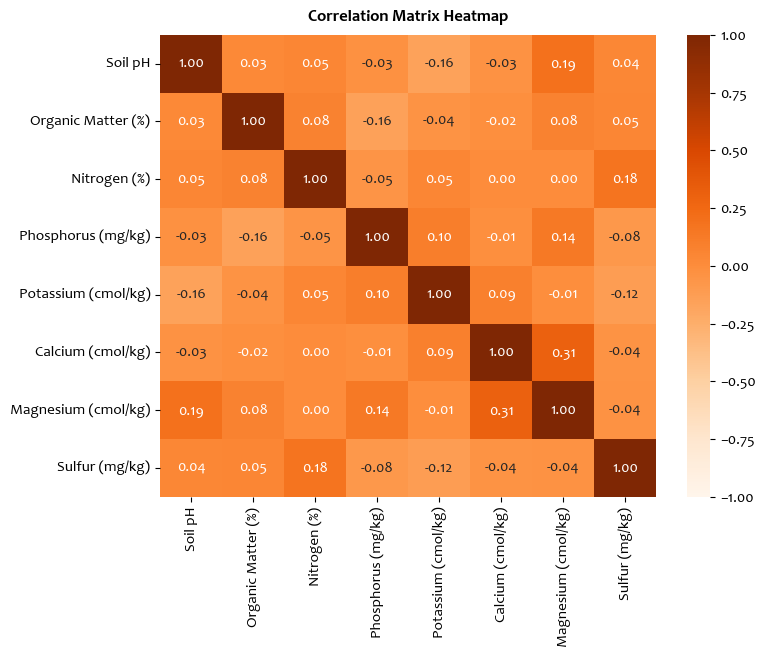

In [111]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Oranges', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap', fontsize=12, fontweight='bold', pad=10)
plt.grid(False)
plt.show()

<h3 style='font-size: 18px; font-family: Colonna MT; font-weight: 600'>8.3: Pearson’s</h3>

**Pearson’s r**: This measures the strength and direction of the linear relationship between two continuous variables. Values range from -1 to 1, with 0 indicating no relationship, 1 indicating a perfect positive relationship, and -1 indicating a perfect negative relationship.

In [77]:
from scipy.stats import pearsonr

def compute_pearson_r(df, numerical_columns):
    results = []

    for i, col1 in enumerate(numerical_columns):
        for col2 in numerical_columns[i+1:]:
            r_value, p_value = pearsonr(df[col1], df[col2])
            direction = ("Positive" if r_value > 0 else 
                         "Negative" if r_value < 0 else "No correlation")
            strength = ("Strong" if abs(r_value) >= 0.7 else 
                        "Moderate" if abs(r_value) >= 0.3 else "Weak")

            results.append({
                'Variable 1': col1, 'Variable 2': col2,
                'Pearson\'s r': r_value, 'P-value': p_value,
                'Direction': direction, 'Strength': strength
            })
    
    return pd.DataFrame(results)

Variables = df.select_dtypes(include=[np.number]).columns
pearson_results_df = compute_pearson_r(df, Variables)
pearson_results_df.sample(10)

,Variable 1,Variable 2,Pearson's r,P-value,Direction,Strength
5,Soil pH,Magnesium (cmol/kg),0.19,0.02,Positive,Weak
14,Organic Matter (%),Sulfur (mg/kg),0.05,0.56,Positive,Weak
8,Soil pH,Iron (mg/kg),0.03,0.69,Positive,Weak
35,Calcium (cmol/kg),Magnesium (cmol/kg),0.31,0.00,Positive,Moderate
4,Soil pH,Calcium (cmol/kg),-0.03,0.68,Negative,Weak
1,Soil pH,Nitrogen (%),0.05,0.55,Positive,Weak
30,Potassium (cmol/kg),Calcium (cmol/kg),0.09,0.27,Positive,Weak
44,Zinc (mg/kg),Iron (mg/kg),-0.02,0.76,Negative,Weak
33,Potassium (cmol/kg),Zinc (mg/kg),-0.04,0.59,Negative,Weak
27,Phosphorus (mg/kg),Sulfur (mg/kg),-0.08,0.33,Negative,Weak


<h1 style='font-size: 20px;  font-weight: 600'>5.0: Parametictic Test Assumption Validation</h1>

Before we advance to hypothesis testing — specifically the one-sample t-test — it's important to first check whether our variables meet the assumptions required for parametric tests, particularly **normality**. To do this, we’ll use the **Shapiro-Wilk test**, which helps us assess if the distribution of each variable is close to normal. This step ensures the validity of our statistical tests and guides us in choosing the right analysis methods.


In [78]:
def ShapirowilkTest(df):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) == 0:
        raise ValueError("No numerical columns found in the DataFrame.")
    
    results = []
    for col in numerical_cols:
        stat, p_value = shapiro(df[col])
        results.append({
            'Variable': col,
            'Statistic': stat,
            'P-Value': p_value,
            'Normality': 'Normally Distributed' if p_value > 0.05 else 'Not Normally Distributed'
        })
    
    results_df = pd.DataFrame(results)
    
    return results_df

shapiro_results = ShapirowilkTest(df)
display(shapiro_results)

,Variable,Statistic,P-Value,Normality
0,Soil pH,0.99,0.30,Normally Distributed
1,Organic Matter (%),0.99,0.29,Normally Distributed
2,Nitrogen (%),0.99,0.75,Normally Distributed
3,Phosphorus (mg/kg),0.99,0.47,Normally Distributed
4,Potassium (cmol/kg),0.99,0.36,Normally Distributed
5,Calcium (cmol/kg),0.99,0.88,Normally Distributed
6,Magnesium (cmol/kg),0.99,0.57,Normally Distributed
7,Sulfur (mg/kg),0.99,0.78,Normally Distributed
8,Zinc (mg/kg),1.00,0.98,Normally Distributed
9,Iron (mg/kg),0.99,0.14,Normally Distributed


<h1 style='font-size: 18px;'>6.0: Hypothesis Testing (One-Sample t-Test)</h1>

Now, let’s dive into the core of our analysis — hypothesis testing using a one-sample t-test — to assess whether the soil parameters we've measured truly align with the recommended standards for healthy crop growth. For each parameter (such as nitrogen, phosphorus, pH, etc.), we’ll formulate two hypotheses: the **null hypothesis (H₀)** assumes that the average value matches the ideal agronomic level, while the **alternative hypothesis (H₁)** suggests a significant difference, indicating a potential issue. In simple terms, we’re asking: *Does the average value we found reflect what’s best for crops?* To answer this, we’ll perform a t-test that compares each observed mean to its standard reference value. If a statistically significant difference is detected, it means the deviation is unlikely due to random chance, signaling that specific soil properties may need interventions like nutrient adjustments, pH correction, or organic matter enhancement to support optimal crop performance.

<h4 style='font-size: 15px;'>6.1: One-Sample t-Test</h4>

Now, we’ll perform the t-test for each parameter. This test will compare the average value we observed to the standard reference value. If we find a statistically significant difference, it means that the variation we’re seeing is unlikely to be due to random chance. This is our signal that the soil property in question may require management — maybe a boost in nutrients, pH adjustment, or organic matter improvement.

In [117]:
def one_sample_t_test(df, columns, population_means, alpha=0.05):
    results = []
    for col in columns:
        if col in df.columns and col in population_means:
            sample_data = df[col].dropna()
            pop_mean = population_means[col]
            
            t_stat, p_value = ttest_1samp(sample_data, pop_mean)
            mean_diff = sample_data.mean() - pop_mean
            interpretation = "Significant" if p_value < alpha else "Not Significant"
            
            results.append({
                "Parameter": col,
                "Sample Mean": sample_data.mean(),
                "Recommended Mean": pop_mean,
                "Mean Difference": mean_diff,
                "T-Statistic": t_stat,
                "P-Value": p_value,
                "Significance": interpretation
            })
    return pd.DataFrame(results)

# Recommended agronomic values
recommended_values = {
    "Soil pH": 6.5,
    "Organic Matter (%)": 3.0,  # in %
    "Nitrogen (%)": 0.2,        # in %
    "Phosphorus (mg/kg)": 15.0,     # in mg/kg
    "Potassium (cmol/kg)": 0.2,       # in cmol/kg
    "Calcium (cmol/kg)": 5.0,         # in cmol/kg
    "Magnesium (cmol/kg)": 1.5,       # in cmol/kg
    "Sulfur (mg/kg)": 10.0,         # in mg/kg
    "Zinc (mg/kg)": 1.0,            # in mg/kg
    #"Iron (mg/kg)": 5.0             # in mg/kg
}

results_df = one_sample_t_test(df, df.columns, recommended_values)
results_df

,Parameter,Sample Mean,Recommended Mean,Mean Difference,T-Statistic,P-Value,Significance
0,Soil pH,6.47,6.50,-0.03,-0.70,0.48,Not Significant
1,Organic Matter (%),2.75,3.00,-0.25,-5.27,0.00,Significant
2,Nitrogen (%),0.25,0.20,0.05,11.78,0.00,Significant
3,Phosphorus (mg/kg),18.92,15.00,3.92,10.42,0.00,Significant
4,Potassium (cmol/kg),0.82,0.20,0.62,37.11,0.00,Significant
5,Calcium (cmol/kg),10.37,5.00,5.37,20.79,0.00,Significant
6,Magnesium (cmol/kg),1.54,1.50,0.04,1.54,0.13,Not Significant
7,Sulfur (mg/kg),12.00,10.00,2.00,8.15,0.00,Significant


<h4 style='font-size: 15px;'>6.2: Results Table</h4>

The table below presents the results of the one-sample t-tests, showing the sample means, hypothesized agronomic values, test statistics, p-values, and conclusions—clearly identifying which soil parameters significantly differ from recommended benchmarks.

In [118]:
display(results_df)

,Parameter,Sample Mean,Recommended Mean,Mean Difference,T-Statistic,P-Value,Significance
0,Soil pH,6.47,6.50,-0.03,-0.70,0.48,Not Significant
1,Organic Matter (%),2.75,3.00,-0.25,-5.27,0.00,Significant
2,Nitrogen (%),0.25,0.20,0.05,11.78,0.00,Significant
3,Phosphorus (mg/kg),18.92,15.00,3.92,10.42,0.00,Significant
4,Potassium (cmol/kg),0.82,0.20,0.62,37.11,0.00,Significant
5,Calcium (cmol/kg),10.37,5.00,5.37,20.79,0.00,Significant
6,Magnesium (cmol/kg),1.54,1.50,0.04,1.54,0.13,Not Significant
7,Sulfur (mg/kg),12.00,10.00,2.00,8.15,0.00,Significant


<h1 style='font-size: 18px;'>7.0: Visual Explorations</h1>

To gain a more intuitive understanding of how each soil parameter compares to its recommended value, we visualize the results using bar plots. These plots make it easier to identify which parameters deviate noticeably and help highlight statistically significant differences at a glance.


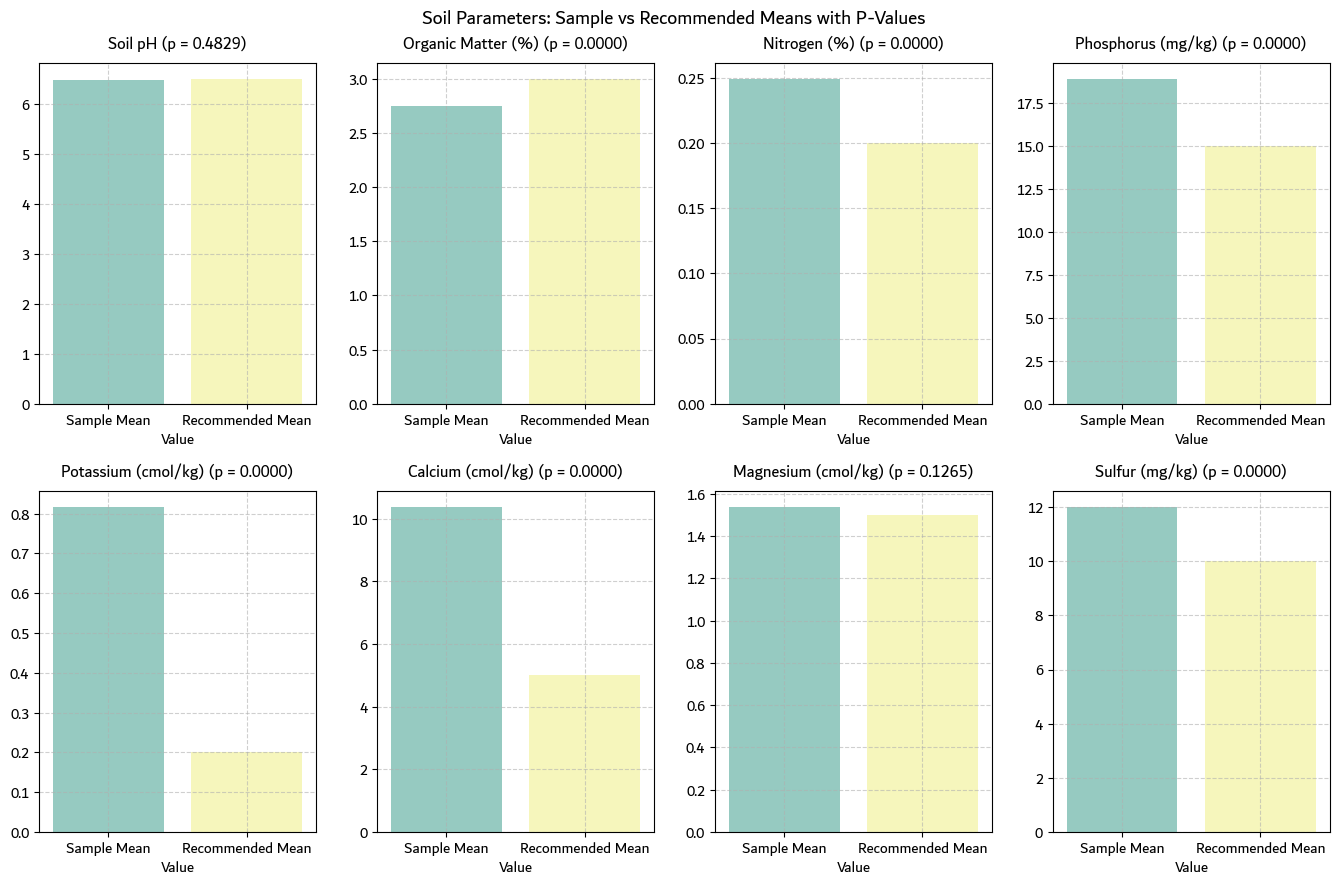

In [122]:
def reshape_results_for_facet_plot(results_df):
    melted = pd.melt(
        results_df,
        id_vars=["Parameter", "P-Value", "Significance"],
        value_vars=["Sample Mean", "Recommended Mean"],
        var_name="Type",
        value_name="Value"
    )
    return melted

def plot_variable_distributions_with_pvalues(data, group_col="Parameter", p_col="P-Value"):
    Variables = data[group_col].unique()
    num_variables = len(Variables)
    
    cols = 4
    rows = math.ceil(num_variables / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(3.4*cols, 4.5*rows))
    plt.rcParams.update({'font.family': 'Dubai', 'font.size': 11})
    axes = axes.flatten() if num_variables > 1 else [axes]

    for idx, variable in enumerate(Variables):
        subset = data[data[group_col] == variable]
        
        # Extract unique p-value for this parameter
        p_val = subset[p_col].dropna().unique()
        p_val_str = f" (p = {p_val[0]:.4f})" if len(p_val) > 0 else ""

        sns.barplot(
            data=subset,
            y="Value", x="Type",
            ax=axes[idx],
            hue = 'Type',
            palette="Set3",
            linewidth=0.9,
            alpha=1
        )

        axes[idx].set_title(f"{variable}{p_val_str}", fontsize=12, pad=10)
        axes[idx].set_xlabel("Value")
        axes[idx].set_ylabel("")
        axes[idx].grid(linestyle='--', alpha=0.6)
        axes[idx].legend_.remove() if axes[idx].get_legend() else None

    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.suptitle("Soil Parameters: Sample vs Recommended Means with P-Values", fontsize=14)
    plt.show()

# Example usage:
data = reshape_results_for_facet_plot(results_df)
plot_variable_distributions_with_pvalues(data)


---

This analysis was performed by **Jabulente**, a passionate and dedicated data scientist with a strong commitment to using data to drive meaningful insights and solutions.

---

<h5 style='font-size: 65px; color: crimson; font-family: Colonna MT; font-weight: 600; text-align: center'>THE END</h5>